In [170]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import os
import logging
import pathlib
from mnist_data import (
    train_images,
    train_labels,
    test_images,
    test_labels
)

In [171]:

from mnist_utils import plot_samples
from config import cfg
from vanilla_model import fit as fit_vanilla
from metrics import calc_metrics
from converters import keras_to_tflite, dynamic_range_quantization, check_quantized_model, eight_bit_quantization
from eval import eval_quantized_model
from config import cfg
from eval import run_tflite_model
from c_utils import write_model_h
from utils import save_test_data
import plot_utils as pu

In [172]:
from nyuv2_torch_ds_adapter import get_tf_nyuv2_ds
import argparse
args = argparse.Namespace()
args.truncate_testset = False
# args.target_size = (64, 64)
args.crop_size = (640, 480)
args.target_size = (64, 64)
# args.target_size = (480,640)
args.out_fold_ratio = 1
args.is_maxim = False
ds_train, ds_val, ds_test = get_tf_nyuv2_ds(args)
# x=next(iter(ds_train.shuffle(100).batch(2).take(1)))
# pu.plot_sample_nyuv2(x)
train_size=20
ds_train = ds_train.batch(2).take(train_size)
test_size=20
ds_val = ds_val.batch(2).take(test_size)

Dataset: NYU Depth V2
# of train images: 50688
Dataset: NYU Depth V2
# of test images: 654


In [179]:
from loss import calculate_loss
from model import get_model
keras.backend.clear_session()
# loss = tf.keras.losses.MeanSquaredError()
metrics = tf.keras.metrics.MeanSquaredError()
# Build model
fp_model = get_model(cfg.img_size, cfg.num_classes, in_channels=cfg.in_channels)
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
fp_model.compile(optimizer=optimizer, loss=calculate_loss, metrics=metrics)

es = tf.keras.callbacks.EarlyStopping(
    patience=cfg.es_patience, restore_best_weights=True
)
history = fp_model.fit(
    x=ds_train,
    epochs=cfg.epochs*3,
    validation_data=ds_val,
    # callbacks=[es],
    verbose=1
)

Epoch 1/90


TypeError: in user code:

    File "/home/master/.conda/envs/sc/lib/python3.9/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)

    TypeError: tf__calculate_loss() missing 1 required positional argument: 'pred'


1/1 [==============================] - 0s 51ms/step
MAE: 0.06, RMSE: 0.00, loss: 0.00


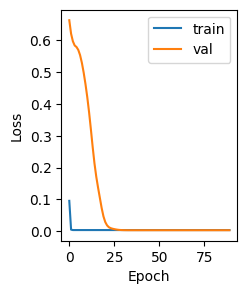

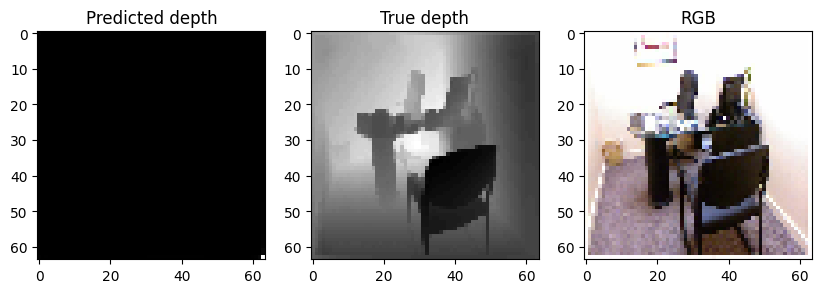

In [177]:
def plot_eval_results(pred_depth, true_depth, rgb):
    mae = np.mean(np.abs(pred_depth - true_depth))
    rmse = (np.mean(np.square(pred_depth - true_depth)))
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, loss: {loss(pred_depth, true_depth):.2f}")
    plt.figure(figsize=(5, 3))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    # plt.subplot(1, 2, 2)
    fix, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(pred_depth[..., 0], cmap="gray")
    axs[0].set_title("Predicted depth")
    axs[1].imshow(true_depth[..., 0], cmap="gray")
    axs[1].set_title("True depth")
    axs[2].imshow(rgb)
    axs[2].set_title("RGB")
    plt.show()

x_val= next(iter(ds_val))
x_train= next(iter(ds_train))
out = fp_model.predict(ds_train)
plot_eval_results(out[0], x_train[1][0], x_train[0][0]/255)

In [178]:
fp_model.eval(ds_train)

AttributeError: 'Functional' object has no attribute 'eval'

In [176]:
out.min(), out.max(), x_train[1][0].numpy().min(), x_train[1][0].numpy().max()

(5.3112414e-13, 0.43694445, 0.029, 0.092875004)

In [ ]:
loss(out[0], x_train[1][0])


<tf.Tensor: shape=(), dtype=float32, numpy=0.3487337>